In [78]:
import numpy as np
from tqdm.notebook import tqdm
from FITX import fit_risetime
from matplotlib import pyplot as plt
from aps_figures.aps_one_column import *
from scipy.signal import hilbert
from growth_damp_utils import *
folder = '/home/gubaidulin/scripts/experiments/growth_damp_measurements/FBT_grow_time_17_04_2023/'
dat = np.load(folder+'21_43_36_500mA.npy')
C = 354
from scipy.constants import c
t_delay = 10e-9
tau_delay = t_delay/(C/c)
bunch_number = 7
risetimes = []
for bunch_number in tqdm(range(0, 416)):
    dat_no_mean = dat[bunch_number][:]-np.mean(dat[bunch_number][:])
    signal = np.abs(hilbert(dat_no_mean))
    # fig, ax = plt.subplots(1, 1)
    # ax.plot(signal)
    # min_level = 5.*np.mean(signal[:200])
    min_level = np.min((5.*np.mean(signal[:200]), 5.*np.mean(signal[-200:])))
    smoothing_window_size = 50
    rx = fit_risetime(signal,
                      min_level=min_level, 
                      smoothing_window_size=smoothing_window_size,
                      matplotlib_axis=None)
    risetimes.append(rx)

  0%|          | 0/416 [00:00<?, ?it/s]

## Single-bunch analysis

Window width 2000
Bunch #350 risetime -1006360.7, bunch #350 damping time 194534.7


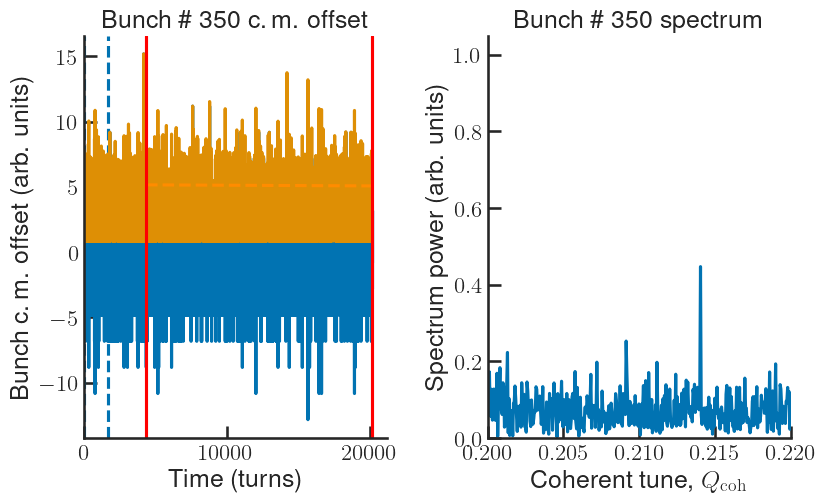

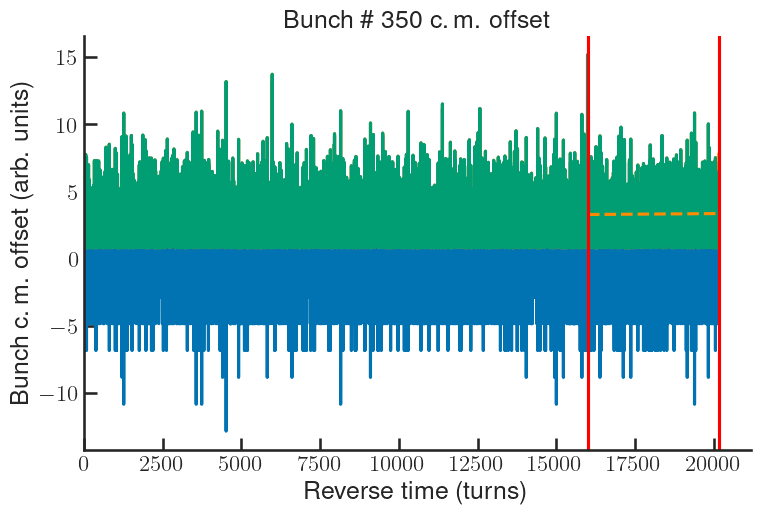

In [121]:
%matplotlib inline
import h5py as hp
from numpy.fft import rfft, rfftfreq
folder = '/home/gubaidulin/scripts/experiments/growth_damp_measurements/FBT_grow_time_21_05_2023/'
bunchnumber = 350
filename = 'growth_damp_7.1mA_15_54_25'
fig, ax = plt.subplots(1, 2)
f = hp.File(folder+filename+'.hdf5')
window_delay = np.array(f['window_delay'])
window_width = np.array(f['window_width'])
print('Window width', window_width)
f.close()
plot_bunch_offset_data(ax[0], bunchnumber=bunchnumber, filename=filename,
                               folder=folder)

risetime = plot_bunch_risetime_fit(ax[0], bunchnumber=bunchnumber, filename=filename,
                               folder=folder)
plot_bunch_spectrum_data(ax[1], bunchnumber=bunchnumber, filename=filename,
                               folder=folder)
ax[1].set_xlim(0.2, 0.22)
# ax[0].set_xlim(0, 4000)
plt.tight_layout()
fig, ax = plt.subplots(1, 1)
damping_time = plot_bunch_damping_time_fit(ax, bunchnumber=bunchnumber, filename=filename,
                               folder=folder, show_fitted_signal=True)
print('Bunch #{0:} risetime {1:.1f}, bunch #{0:} damping time {2:.1f}'.format(int(bunchnumber), risetime, damping_time))

### Beam analysis

Beam risetime -179772.3, beam damping time -153037.5
Ion frequencies H 68.3, 10.9, CO 18.2, 2.9, CO2 14.6, 2.3


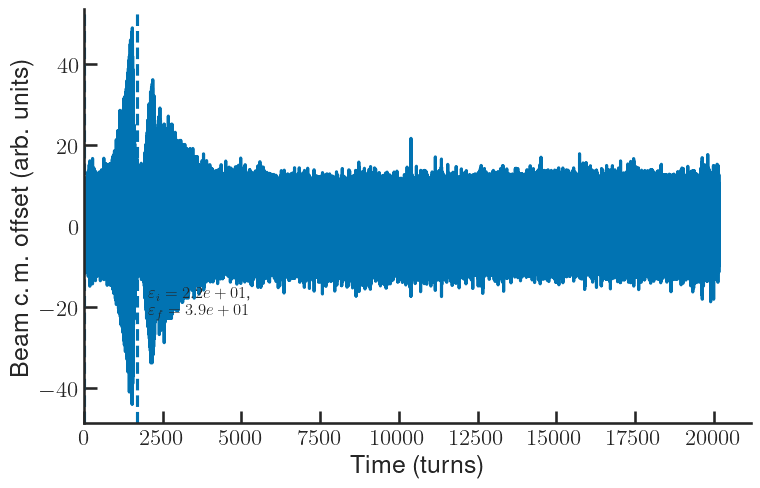

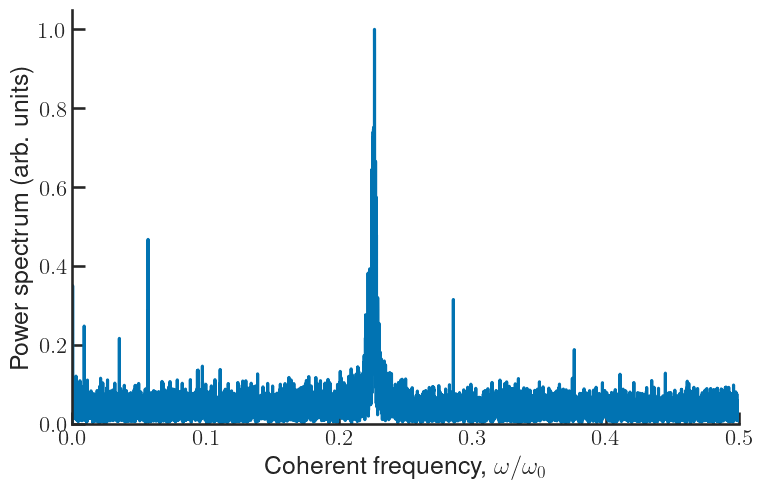

In [85]:
fig, ax = plt.subplots(1, 1)
beam_risetime, beam_damping_time = plot_beam_offset_data(ax, folder=folder, filename=filename)
print('Beam risetime {:.1f}, beam damping time {:.1f}'.format(risetime, damping_time))
fig, ax = plt.subplots(1, 1)
plot_beam_spectrum(ax, folder=folder, filename=filename)
# fig, ax = plt.subplots(1, 1)
# ax.plot(filling_pattern_before, label='before', marker='.')
# ax.plot(filling_pattern_after, linestyle='dashed', label='after')
# ax.set_xlim(0, 416)
# ax.set_ylabel('Current per bunch, $I_\mathrm{bunch}$ (mA)')
# ax.set_xlabel('Bunch index')
# ax.title.set_text('Filling pattern')
# plt.figlegend()
# fig, ax = plt.subplots(1, 1)

In [87]:
from scipy.signal import spectrogram
mean_y, t0, t1,  emitYC02before, emitYC16before, emitYC02after, emitYC16after, emitXC02before, emitXC02after = read_bunch_data(300, filename, folder)
mean_y -= np.mean(mean_y)
f, t, Sxx = spectrogram(mean_y)
Sxx_max = np.max(np.abs(Sxx))
fig, ax = plt.subplots(1, 1)
ax.pcolormesh(t, f, np.log(Sxx/Sxx_max),
              shading='gouraud',
              cmap='binary',
              vmax = 0,
              vmin = -5,
              rasterized=True
             )
# ax.set_ylim(0.2, 0.23)

In [71]:
mean_y_bunch, t0, t1,  emitYC02before, emitYC16before, emitYC02after, emitYC16after, emitXC02before, emitXC02after = read_bunch_data(0, filename, folder)
size = mean_y_bunch.shape[0]
mean_y_beam = np.empty(shape=(size*H_RF), dtype=np.float64)
turns = np.linspace(0, size, H_RF*size)
phases = []
for bunchnumber in range(0, H_RF):
    mean_y_bunch, t0, t1,  emitYC02before, emitYC16before, emitYC02after, emitYC16after, emitXC02before, emitXC02after = read_bunch_data(bunchnumber, filename, folder)
    mean_y_bunch -= np.mean(mean_y_bunch)
    mean_y_beam[bunchnumber::H_RF] = mean_y_bunch
    fft_mean = rfft(mean_y_bunch)
    index = np.where(np.abs(fft_mean)==np.max(np.abs(fft_mean)))
    phase = np.arctan2(np.real(fft_mean)[index], np.imag(fft_mean)[index])
    phases.append(phase)

In [77]:
plt.plot(phases)
plt.xlim(200, 210)

(200.0, 210.0)

In [20]:
fig, ax = plt.subplots(1, 1)
f, t, Sxx = spectrogram(mean_y_beam)
ax.pcolormesh(t, f, np.log(Sxx/Sxx_max),
              shading='gouraud',
              cmap='binary',
              vmax = 0,
              vmin = -5,
              rasterized=True
             )

(13000.0, 13001.0)

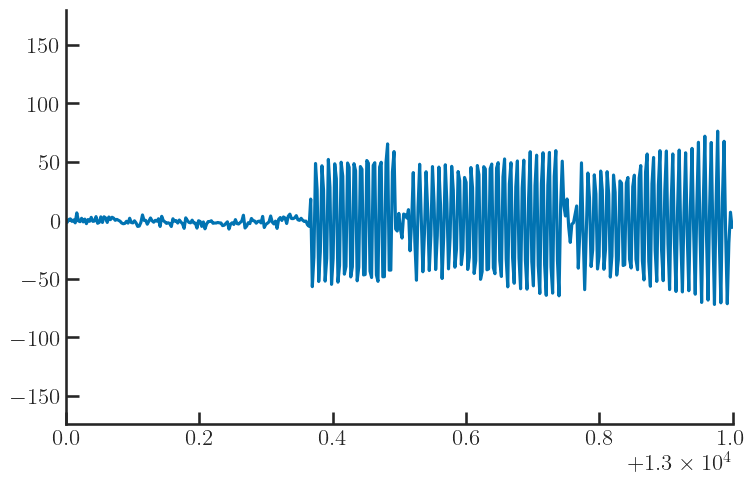

In [47]:
t = np.linspace(0, mean_y_bunch.shape[0], mean_y_beam.shape[0])
plt.plot(t, mean_y_beam)
plt.xlim(13000, 13001)

(0.0, 50.0)

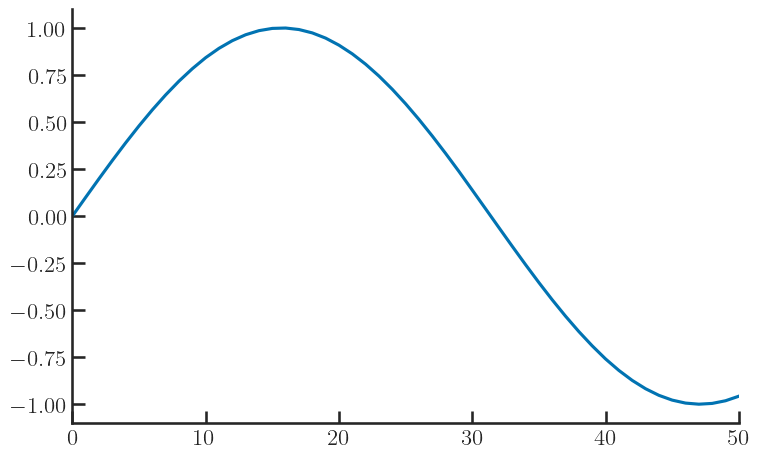

In [34]:
t = np.linspace(0, 1000, 1000)
signal_sample = np.sin(t)
dt = 0.1
# plt.plot(rfftfreq(signal_sample.shape[0]), np.abs(rfft(signal_sample)))
stitched_signal = np.empty(shape=(10000,))
for i in range(0, 10):
    stitched_signal[i::10] = np.sin(t+dt*i)
plt.plot(stitched_signal)
plt.xlim(0, 50)

In [4]:
bunch_number = 250
# for bunch_number in range(0, 416, 1):
dat_no_mean = dat[bunch_number][:]-np.mean(dat[bunch_number][:])
signal = np.abs(hilbert(dat_no_mean))
fig, ax = plt.subplots(1, 1)
ax.plot(dat_no_mean, label='data reading')
# ax.plot(signal, label='amplitude estimation')
min_level = np.min((5.*np.mean(signal[:200]), 5.*np.mean(signal[-200:])))
print('min level for a fit {:.1f}'.format(min_level))

# risetimes2 = []
smoothing_window_size = 10
# for smoothing_window_size in np.linspace(1, 500, 500, dtype=np.int64): 
rx = fit_risetime(signal,
            min_level=min_level, 
            smoothing_window_size=smoothing_window_size,
            matplotlib_axis=ax)
    # print('{:.1e}'.format(rx))
    # risetimes2.append(rx)
ax.title.set_text('Bunch \# {0:}, Rise time {1:.0f} turns'.format(int(bunch_number), rx))
ax.legend(loc = 'lower right')
ax.axvline(tau_delay, color='grey', linestyle='dashed')
ax.axvline(tau_delay+fbt_window, color='grey', linestyle='dashed')
ax.text(tau_delay+fbt_window/2, 1.25*np.max(signal), 'FBT off window')
ax.set_xlim(0, )
ax.set_ylim(np.min(dat_no_mean), 1.5*np.max(signal))
ax.set_xlabel('Time (turns)')
ax.set_ylabel('Vert. position (arb. units)')
plt.savefig('Measurement example.svg')
from numpy.fft import rfft, rfftfreq
fft_mean = np.abs(rfft(dat_no_mean))
fftfreq_mean = rfftfreq(dat_no_mean.shape[0])

# fig, ax = plt.subplots(1, 1)
# ax.plot(risetimes2)
fig, ax = plt.subplots(1, 1)
ax.plot(fftfreq_mean, fft_mean)
ax.set_xlabel('Tune, $Q_y+\Delta Q_\mathrm{coh}$')
ax.set_ylabel('Spectrum power')
ax.title.set_text('Bunch \# {0:}'.format(int(bunch_number), rx))
ax.set_xlim(.205, .215)

min level for a fit 25.6


NameError: name 'fbt_window' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1)
risetimes = np.array(risetimes)
risetimes[risetimes < 0] = None
risetimes[risetimes > 2000] = None
risetimes[np.isnan(risetimes)] = None
ax.plot(range(1, risetimes.shape[0]+1),risetimes)
# ax.set_ylim(-0, 600)
ax.set_xlabel('Bunch index')
ax.set_ylabel('Risetime (turns)')
# ax.set_xlim(0, 4000)
# ax.title.set_text('Risetime {:.1f} (turns)'.format(rx))
# from scipy.constants import c
# FBT_window = 2000e-6
# print('Revolution period {:.1e} (s)'.format(T))
# print('FBT window {:.2f} (turns)'.format(FBT_window/T))
ax.title.set_text('Risetime (Mean {:.1f}, Standard deviation {:.1f})'.format(np.nanmean(risetimes), np.nanstd(risetimes)))
plt.savefig('risetimes.svg')
fig, ax  = plt.subplots(1, 1)
ax.hist(risetimes)
ax.set_xlabel('Risetime (turns)')
ax.set_ylabel('Count')
ax.title.set_text('Histogram of risetimes')
plt.savefig('risetimes_hist.svg')

In [ ]:
from numpy.fft import rfft, rfftfreq
fig, ax = plt.subplots(1, 1)
risetimes[np.isnan(risetimes)] = np.nanmean(risetimes)
signal_for_fft = risetimes-np.nanmean(risetimes)
risetimes_fft = rfft(signal_for_fft)
risetimes_fftfreq = rfftfreq(signal_for_fft.shape[0])
ax.plot(risetimes_fftfreq, np.abs(risetimes_fft))

In [ ]:
%matplotlib agg